# DA623 Tutorial
## Topic: Demystifying 1D convolution
Submission by: 
**VISHAL BULCHANDANI(Roll no. 200101108)**

B.Tech.(Computer Science and Engineering)



In [19]:
import numpy as np
import scipy
import plotly
import matplotlib.pyplot as plt
import pandas as pd
import IPython.display as display
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.animation as animation
import tabulate
import librosa
import torch
import torchaudio
import torchaudio.functional as F

%matplotlib inline



# A Probability Problem:
To introduce convolution we take a simple problem in probability:
We take a balanced die. Probability distribution of the number rolled is as follows:

| X    | 1   | 2   | 3   | 4   | 5   | 6   |
|------|-----|-----|-----|-----|-----|-----|
| p(X) | 1/6 | 1/6 | 1/6 | 1/6 | 1/6 | 1/6 |

Now suppose we are rolling 2 dies:

We need to find the probability distribution of sum of the results:

We can do it via a 2D table:
| X | 1    | 2    | 3    | 4    | 5    | 6    |
|---|------|------|------|------|------|------|
| 1 | 1/36 | 1/36 | 1/36 | 1/36 | 1/36 | 1/36 |
| 2 | 1/36 | 1/36 | 1/36 | 1/36 | 1/36 | 1/36 |
| 3 | 1/36 | 1/36 | 1/36 | 1/36 | 1/36 | 1/36 |
| 4 | 1/36 | 1/36 | 1/36 | 1/36 | 1/36 | 1/36 |
| 5 | 1/36 | 1/36 | 1/36 | 1/36 | 1/36 | 1/36 |
| 6 | 1/36 | 1/36 | 1/36 | 1/36 | 1/36 | 1/36 |

and the distribution is:
| X      | 2    | 3    | 4    | 5    | 6    | 7    | 8    | 9    | 10   | 11   | 12   |
|--------|------|------|------|------|------|------|------|------|------|------|------|
| p(sum) | 1/36 | 2/36 | 3/36 | 4/36 | 5/36 | 6/36 | 5/36 | 4/36 | 3/36 | 2/36 | 1/36 |

one of the ways in which this could be generated is:
take 2 dices A and B and revert the probability distribution of A:
and calculate using a sliding window:

| A    | 1    | 2    | 3    | 4    | 5    | 6    |      |      |      |      |      |
|------|------|------|------|------|------|------|------|------|------|------|------|
| p(A) | 1/36 | 1/36 | 1/36 | 1/36 | 1/36 | 1/36 |      |      |      |      |      |
| B    |      |      |      |      |      | 6    | 5    | 4    | 3    | 2    | 1    |
| p(B) |      |      |      |      |      | 1/36 | 1/36 | 1/36 | 1/36 | 1/36 | 1/36 |

Here we slide the B distribution to the right and multiply the coinciding rows and add the columns to get the probability:
$$
P(6+6) = \frac{1}{6} \times \frac{1}{6} 
$$

| A    | 1    | 2    | 3    | 4    | 5    | 6    |      |      |      |      |   |
|------|------|------|------|------|------|------|------|------|------|------|---|
| p(A) | 1/36 | 1/36 | 1/36 | 1/36 | 1/36 | 1/36 |      |      |      |      |   |
| B    |      |      |      |      | 6    | 5    | 4    | 3    | 2    | 1    |   |
| p(B) |      |      |      |      | 1/36 | 1/36 | 1/36 | 1/36 | 1/36 | 1/36 |   |

$$
P(5+6) = \frac{1}{6} \times \frac{1}{6}  +  \frac{1}{6} \times \frac{1}{6} = \frac{2}{36}
$$

| A    | 1    | 2    | 3    | 4    | 5    | 6    |      |      |      |   |   |
|------|------|------|------|------|------|------|------|------|------|---|---|
| p(A) | 1/36 | 1/36 | 1/36 | 1/36 | 1/36 | 1/36 |      |      |      |   |   |
| B    |      |      |      | 6    | 5    | 4    | 3    | 2    | 1    |   |   |
| p(B) |      |      |      | 1/36 | 1/36 | 1/36 | 1/36 | 1/36 | 1/36 |   |   |

$$
P(10) = \frac{1}{6} \times \frac{1}{6}  +  \frac{1}{6} \times \frac{1}{6} + \frac{1}{6} \times \frac{1}{6}= \frac{3}{36}
$$


and so on...
to calculate each of the probability.

Observe that we here we revert the array of probability and then use it as a sliding window to calculate the results.
This operation is observed in many places in mathematics and is called a **convolution**.


### What is convolution:
Take arrays A and B:

$$
\begin{split}
A & = [a_1,a_2,a_3,\ldots, a_m] \\
B & = [b_1,b_2,b_3, \ldots, b_n]
\end{split}


$$
Convolution of A and B is defined by taking the reverse of array A and then sliding it across B and calculating the sum of products.

$$
(A * B)[n] = \sum_{m=0}^{M-1} A[m] \cdot B[n - m]

$$

where $M = N_A+N_B-1$



In **Python** we have two ways of calculating the convolution of arrays:
```
1. np.convolve()
2. scipy.signals.fftconvolve()

Take the previous probability problem with a weighted dice. The probabilities are shown below:

| X    | 1   | 2   | 3   | 4   | 5   | 6   |
|------|-----|-----|-----|-----|-----|-----|
| p(X) | 0.21 | 0.24 | 0.10 | 0.15 | 0.17 | 0.13 |

We calculate the probability of sum using both convolution and the normal methods.

In [3]:
probs = np.array([0.21,0.24,0.10,0.15,0.17,0.13])

dict= {}
for i in range(len(probs)):
    for j in range(len(probs)):
        if (i+j+2) in dict:
            dict[i+j+2]+=probs[i]*probs[j]
        else:
            dict[i+j+2]=probs[i]*probs[j]



con=np.convolve(probs, probs)

#print("Sum:     Manual Prob:     Convolution")
table=[]
for key, new_prob in zip(dict.keys(), con):
    #print(f"{key:-6d}   {dict[key]:.5f}          {new_prob:.5f}")
    table.append([key,format(dict[key],".5f"), format(new_prob,'.5f')])


print(tabulate.tabulate(table, headers=['Sum','Manual Probability', 'Convolution Probability'],tablefmt='pretty'))


+-----+--------------------+-------------------------+
| Sum | Manual Probability | Convolution Probability |
+-----+--------------------+-------------------------+
|  2  |      0.04410       |         0.04410         |
|  3  |      0.10080       |         0.10080         |
|  4  |      0.09960       |         0.09960         |
|  5  |      0.11100       |         0.11100         |
|  6  |      0.15340       |         0.15340         |
|  7  |      0.16620       |         0.16620         |
|  8  |      0.11890       |         0.11890         |
|  9  |      0.07700       |         0.07700         |
| 10  |      0.06790       |         0.06790         |
| 11  |      0.04420       |         0.04420         |
| 12  |      0.01690       |         0.01690         |
+-----+--------------------+-------------------------+


As you can see the convolution function values match the value of the probabilities desired. 
In general in fact for 2 random variables: $X$ and $Y$
if their probability distribution functions are of form $$P(X) , P(Y)$$
Then the probability distribution of $X+Y$ is given as:
$$
P(X+Y) = P(X) * P(Y)
$$
where * represents convolution.

Now lets see a simple example of convolution:


In [4]:
A = [1,2]
B= [3,4,5]

print(np.convolve(A,B))
print(scipy.signal.fftconvolve(A,B))
print("Both of them give same output. So what is the difference?")

[ 3 10 13 10]
[ 3. 10. 13. 10.]
Both of them give same output. So what is the difference?


now as we mentioned, there are 2 ways of calculating convolution in Python:

1. np.convolve()
2. scipy.signal.fftconvolve()

Both give identical outputs but there is a difference

Let us see the difference between them.

In [5]:
A = np.random.randn(10000)
B = np.random.randn(10000)

# we time both the functions
%timeit np.convolve(A,B)
%timeit scipy.signal.fftconvolve(A,B)


40 ms ± 420 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
1.45 ms ± 52.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


As you can see there is huge difference between the speed of both the functions despite them calculating the same thing. 
This is because the np.convolve function calculates the convolution by simple elemental multiplication which has a time complexity of $$ O(n^2) $$.
WHereas the scipy.signal.fftconvolve uses the Fast Fourier Transform algorithm to calculate the convolution and has a time complexity of: $$ O(n.log(n)) $$

### Polynomial Multiplication
It is very easy to visualize convolution as a sort of polynomial multiplication.

Take example: 

$$
\begin{split} 
p(x) &= x+5 \\
q(x) &= x^2+5x+6 \\
p(x)q(x) &= (x+5) (x^2+5x+6) \\
&= x^3 + 10x^2 + 31x +30
\end{split}
$$

observe that 
A=[1,5]
B=[1,5,6]

then np.convolve(A,B) gives us the coefficients of the polynomial multiplication. 
This is used in the fftconvolve function to calculate the convolution via calculating the polynomial product through DFT.

In [6]:
A=[1,5]
B=[1,5,6]
print(np.convolve(A,B))
print("These are the coefficients of the multiplied polynomial in decreasing power of x")

[ 1 10 31 30]
These are the coefficients of the multiplied polynomial in decreasing power of x


### Convolution of functions:
Convolution of continuous functions $f_1(t)$ and $f_2(t)$ is defined as:
$$
(f_1*f_2)(t) = \int_{-\infty}^{\infty}f_1(\tau)f_2(t-\tau)d\tau.
$$

Below f1 is the triangle function and f2 is the decreasing exponential function in the postive +x axis

In [7]:
f1 = lambda t: np.maximum(0, 1-abs(t))
f2 = lambda t: (t>0) * np.exp(-2*t)

In [8]:
Fs = 50  # our sampling frequency for the plotting
T = 5    # the time range we are interested in
t = np.arange(-T, T, 1/Fs)  # the time samples

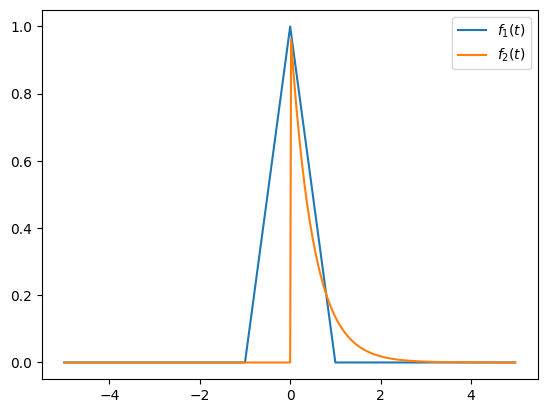

In [9]:
plt.plot(t, f1(t), label='$f_1(t)$')
plt.plot(t, f2(t), label='$f_2(t)$')
plt.legend()

Use the slider below in the figure to find out the convolution at a particular point


In [10]:


def print_convolution_point(t0,f2,f1):
    
    flipped = lambda tau: f2(t0-tau)
    product = lambda tau: f1(tau)*f2(t0-tau)
    
    plt.figure(figsize=(8,3))
    plt.plot(t, f1(t), label=r'$f_1(\tau)$')
    plt.plot(t, flipped(t), label=r'$f_2(t_0-\tau)$')
    plt.plot(t, product(t), label=r'$f_1(\tau)f_2(t_0-\tau)$',color='red')
    plt.fill_between(t,product(t),color='#ff000070')
    plt.legend()
    # Explicitely calculate the integral, using the Simpson integration rule
    display.display(display.HTML(f"Result of the convolution at point x={format(t0,'.2f')} (red shaded area):  {scipy.integrate.simpson(product(t), x=t):.3f}" ))

interact(print_convolution_point,t0=widgets.FloatSlider(value=7.5,
    min=-5,
    max=5.0,
    step=0.05,
    description='Convolution value at point:',
    layout=widgets.Layout(width='50%'),
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
), f1=fixed(f1), f2=fixed(f2));


interactive(children=(FloatSlider(value=5.0, continuous_update=False, description='Convolution value at point:…

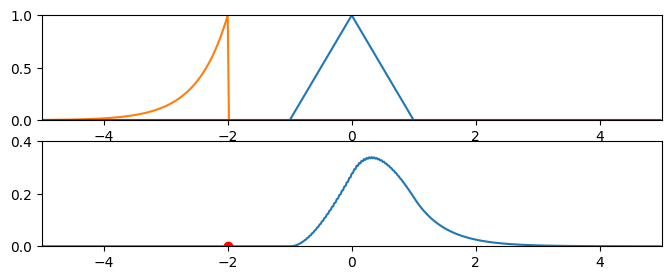

In [12]:
def showConvolution(t0,f1, f2):
    # Calculate the overall convolution result using Simpson integration
    convolution = np.zeros(len(t))
    for n, t_ in enumerate(t):
        prod = lambda tau: f1(tau) * f2(t_-tau)
        convolution[n] = scipy.integrate.simpson(prod(t), x=t)

    # Create the shifted and flipped function
    f_shift = lambda t: f2(t0-t)
    prod = lambda tau: f1(tau) * f2(t0-tau)

    # Plot the curves
    axes[0].clear() # il
    axes[1].clear()
    
    axes[0].set_xlim(-5, 5)
    axes[0].set_ylim(0, 1.0)
    #axes[0].set_ymargin(0.05) # il
    axes[0].plot(t, f1(t), label=r'$f_1(\tau)$')
    axes[0].plot(t, f_shift(t), label=r'$f_2(t_0-\tau)$')
    #axes[0].fill(t, prod(t), color='r', alpha=0.5, edgecolor='black', hatch='//') # il
    axes[0].plot(t, prod(t), 'r-', label=r'$f_1(\tau)f_2(t_0-\tau)$')
    #axes[0].grid(True); axes[0].set_xlabel(r'$\tau$'); axes[0].set_ylabel(r'$x(\tau)$') # il
    #axes[0].legend(fontsize=10) # il
    #axes[0].text(-4, 0.6, '$t_0=%.2f$' % t0, bbox=dict(fc='white')) # il

    # plot the convolution curve
    axes[1].set_xlim(-5, 5)
    axes[1].set_ylim(0, 0.4)
    #axes[1].set_ymargin(0.05) # il
    axes[1].plot(t, convolution, label='$(f_1*f_2)(t)$')

    # recalculate the value of the convolution integral at the current time-shift t0
    current_value = scipy.integrate.simpson(prod(t), x=t)
    axes[1].plot(t0, current_value, 'ro')  # plot the point
    #axes[1].grid(True); axes[1].set_xlabel('$t$'); axes[1].set_ylabel('$(f_1*f_2)(t)$') # il
    #axes[1].legend(fontsize=10) # il
    #plt.show() # il

Fs = 50  # our sampling frequency for the plotting
T = 5    # the time range we are interested in
t = np.arange(-T, T, 1/Fs)  # the time samples
f1 = lambda t: np.maximum(0, 1-abs(t))
f2 = lambda t: (t>0) * np.exp(-2*t)

t0 = np.arange(-2.0,2.0, 0.05)

fig = plt.figure(figsize=(8,3))
axes= fig.subplots(2, 1)
anim = animation.FuncAnimation(fig, showConvolution, frames=t0, fargs=(f1,f2),interval=80)

#anim.save('animation.mp4', fps=30) # fps = frames per second
#plt.show()

from IPython.display import HTML


HTML(anim.to_html5_video())

Let us test and experiment with a bunch of functions:


### Filtering and Smoothing of Signals
Convolution can also be used to perform filtering of signals. 
This is due to the properties of Fast Fourier Transform. Since we know that a convolution in time-domain of 2 signals is the multiplication in their frequency domain. This means by taking an appropriate kernel we can adjust the amplitudes of particular frequencies of a signal. THis can be used to make a huigh-pass, low-pass, band pass filter.

Here is an example that shows smoothing of an ECG signal using both classical signal filter and using convolution.
##### Using scipy.sosfiltfilt

In [13]:

import scipy.io.wavfile


def lowpass(data: np.ndarray, cutoff: float, sample_rate: float, poles: int = 5):
    sos = scipy.signal.butter(poles, cutoff, 'lowpass', fs=sample_rate, output='sos')
    filtered_data = scipy.signal.sosfiltfilt(sos, data)
    return filtered_data

# Load sample data from a WAV file
sample_rate, data = scipy.io.wavfile.read('assets/ecg.wav')
times = np.arange(len(data))/sample_rate

# Apply a 50 Hz low-pass filter to the original data
filtered = lowpass(data, 50, sample_rate)

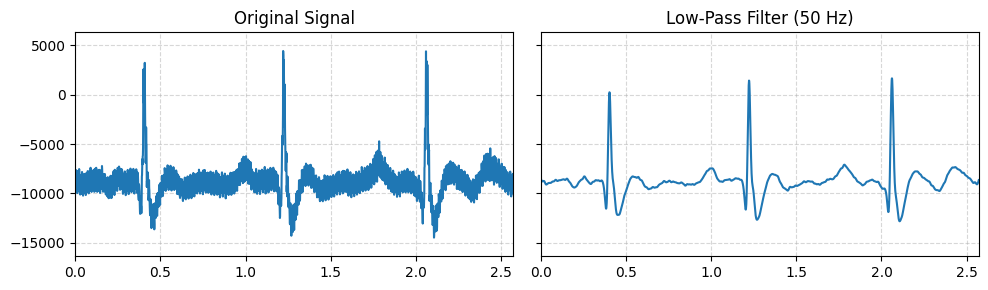

In [14]:
# Code used to display the result
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3), sharex=True, sharey=True)
ax1.plot(times, data)
ax1.set_title("Original Signal")
ax1.margins(0, .1)
ax1.grid(alpha=.5, ls='--')
ax2.plot(times, filtered)
ax2.set_title("Low-Pass Filter (50 Hz)")
ax2.grid(alpha=.5, ls='--')
plt.tight_layout()
plt.show()

#### Filter/smoothing using convolution
An alternative strategy to low-pass a signal is to use convolution. In this method you create a kernel (typically a bell-shaped curve) and convolve the kernel with the signal. The wider the window is the smoother the output signal will be. Also, the window must be normalized so its sum is 1 to preserve the amplitude of the input signal. Note that this method exclusively uses NumPy and does not require SciPy.

There are different for handling data at the edges of the signal, but setting mode to ```valid``` deletes insufficiently filtered points at the edges to produce an output signal that is fully filtered but slightly shorter than the input signal. See numpy.convolve documentation for additional information.

The kernel shape affects the spectral properties of the filter. Commonly called *window functions,* these different shapes produce filtered signals with different frequency response characteristics. The **Hanning window** is preferred for most general purpose signal processing applications. See FftSharp for additional information about the pros and cons of common window functions.

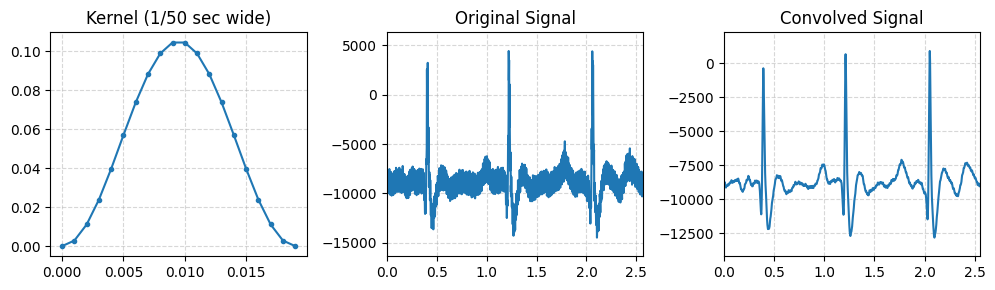

In [15]:
import numpy as np
import scipy.io.wavfile
import matplotlib.pyplot as plt

# Load sample data from a WAV file
sample_rate, data = scipy.io.wavfile.read('assets/ecg.wav')
times = np.arange(len(data))/sample_rate

# create a Hanning kernel 1/50th of a second wide
kernel_width_seconds = 1.0/50
kernel_size_points = int(kernel_width_seconds * sample_rate)
kernel = np.hanning(kernel_size_points)

# normalize the kernel
kernel = kernel / kernel.sum()

# Create a filtered signal by convolving the kernel with the original data
filtered = np.convolve(kernel, data, mode='valid')


# Display the result
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 3))

ax1.plot(np.arange(len(kernel))/sample_rate, kernel, '.-')
ax1.set_title("Kernel (1/50 sec wide)")
ax1.grid(alpha=.5, ls='--')

ax2.plot(np.arange(len(data))/sample_rate, data)
ax2.set_title("Original Signal")
ax2.margins(0, .1)
ax2.grid(alpha=.5, ls='--')

ax3.plot(np.arange(len(filtered))/sample_rate, filtered)
ax3.set_title("Convolved Signal")
ax3.margins(0, .1)
ax3.grid(alpha=.5, ls='--')

plt.tight_layout()
plt.show()

#### Convolution reverb


Convolution reverb is an audio processing technique used to simulate the reverberation of real-world spaces. It relies on impulse responses (IR) which represent the acoustic characteristics of a space. By convolving audio signals with these IRs, convolution reverb creates realistic reverberation effects, adding depth and ambiance to recordings. It's widely used in music production, film, and gaming for its realism and flexibility, allowing users to simulate various environments to suit their needs.

It works on the same principle as FFT convolution that we can modify the amplitude of signals 

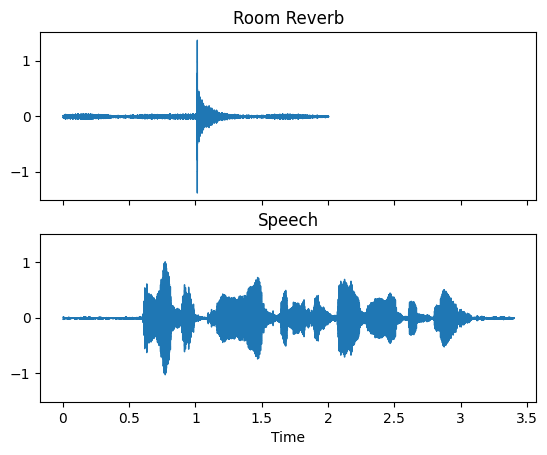

In [20]:
import IPython
from scipy.io import wavfile

sampling_r1,rir = wavfile.read('assets/reverb.wav')
sampling_r2, speech = wavfile.read('assets/speech.wav')


y1, sr = librosa.load('assets/reverb.wav')

fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True)

librosa.display.waveshow(y1, sr=sr, ax=ax[0])

y2, sr = librosa.load('assets/speech.wav')
librosa.display.waveshow(y2, sr=sr, ax=ax[1])

ax[0].set(title='Room Reverb')
ax[1].set(title='Speech')
ax[0].label_outer()
ax[1].label_outer()
IPython.display.display(IPython.display.Audio(filename='assets/reverb.wav'))
IPython.display.display(IPython.display.Audio(filename="assets/speech.wav"))



In [22]:
# Load the impulse response and normalise
rir_raw, sample_rate = torchaudio.load('assets/reverb.wav')
rir = rir_raw[:, int(sample_rate * 1.01) : int(sample_rate * 1.3)]
rir = rir / torch.norm(rir, p=2)

# Load the speech
speech, _ = torchaudio.load('assets/speech.wav')

# Convolve speech with room impulse response
speech_with_reverb = F.fftconvolve(speech, rir)

torchaudio.save('assets/output.wav', speech_with_reverb, sample_rate)

#### See the convolution reverb below!!!

- Reverb Response of the room:

- Original Speech:

- Speech after Convolution reverb:

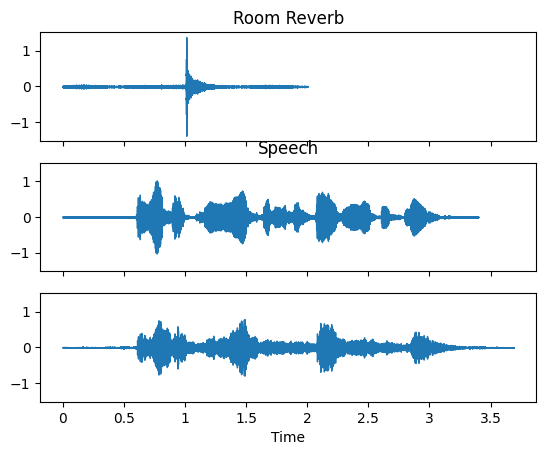

In [33]:
import IPython.display


sampling_r1,rir = wavfile.read('assets/reverb.wav')
sampling_r2, speech = wavfile.read('assets/speech.wav')


y1, sr = librosa.load('assets/reverb.wav')

fig, ax = plt.subplots(nrows=3, sharex=True, sharey=True)

librosa.display.waveshow(y1, sr=sr, ax=ax[0])

y2, sr = librosa.load('assets/speech.wav')
librosa.display.waveshow(y2, sr=sr, ax=ax[1])

ax[0].set(title='Room Reverb')
ax[1].set(title='Speech')
ax[0].label_outer()
ax[1].label_outer()

IPython.display.display(IPython.display.Markdown("- Reverb Response of the room:"), IPython.display.Audio(filename='assets/reverb.wav'))

IPython.display.display(IPython.display.Markdown("- Original Speech:"), IPython.display.Audio(filename="assets/speech.wav"))

IPython.display.display(IPython.display.Markdown("- Speech after Convolution reverb:"), IPython.display.Audio(filename='assets/output.wav'))
y3, sr = librosa.load('assets/output.wav')
librosa.display.waveshow(y3,sr=sr, ax=ax[2])


As you can hear that the reverberation and characteristics of the room have been transferred to the speech. You can try this in different environments. In fact people have done this by taking reverb characteristics from several famous buildings in the world. 